In [16]:
import pandas as pd
import numpy as np
from os import listdir

COLUMNS = ["name", "city", "description", "stars", "price", "rating", "reviews", "image", "images",
           "categoryReviews", "userReviews"]
CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "valueForMoney", "location"]

# reads the file and selects columns
dataframes = []
for file in listdir("../data/"):
    temp_df = pd.read_json(f"../data/{file}")
    temp_df["city"] = file[:-12]
    temp_df = temp_df[COLUMNS]
    dataframes.append(temp_df)
df = pd.concat(dataframes)

# create columns based on review categories
for i, var_name in enumerate(CATEGORIES):
    df[var_name] = df["categoryReviews"].str[i].str['score']

# if duplicate or no reviews are available, drop row
df = df[df["reviews"] > 0]
df = df.dropna()
df = df.drop_duplicates(subset=["name", "city"])

# normalize the values of numerical attributes and adjust buggy prices
df.loc[df["price"] < 5, "price"] = 1000 * df.loc[df["price"] < 10, "price"]
for column in ["stars", "reviews", "rating"] + CATEGORIES:
    df[column] = (df[column] - np.mean(df[column])) / np.std(df[column])

# add the one-hot-encoding for cities
df = pd.concat([df, pd.get_dummies(df["city"])], axis=1)

# change the price to be in log form
df["price"] = np.log(df["price"])

# save it as a csv to be used in other places
df.to_csv("data.csv", index=False)

df

,name,city,description,stars,price,rating,reviews,image,images,categoryReviews,...,new_york,orlando,philadelphia,phoenix,san_antonio,san_diego,san_francisco,san_jose,seattle,toronto
0,The State Hotel,seattle,"The State Hotel features a fitness center, ter...",0.913201,6.212606,0.586815,-0.498419,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.1}, {'title': '...",...,0,0,0,0,0,0,0,0,1,0
1,Hotel Theodore,seattle,You're eligible for a Genius discount at Hotel...,0.913201,5.826000,0.779181,0.081387,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.2}, {'title': '...",...,0,0,0,0,0,0,0,0,1,0
2,"Kimpton Hotel Monaco Seattle, an IHG Hotel",seattle,"Located in Central Seattle, Kimpton Hotel Mona...",0.913201,6.084499,0.298265,-0.522672,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.9}, {'title': '...",...,0,0,0,0,0,0,0,0,1,0
3,Grand Hyatt Seattle,seattle,Less than 10 minutes’ drive from the Space Nee...,2.136803,6.061457,0.875364,-0.224053,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.2}, {'title': '...",...,0,0,0,0,0,0,0,0,1,0
4,citizenM Seattle Pioneer Square,seattle,"Attractively set in Seattle, citizenM Seattle ...",0.913201,5.937536,0.779181,-0.024721,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.2}, {'title': '...",...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,Hampton Inn & Suites Orlando-Apopka,orlando,"Located in Apopka, Florida, this hotel offers ...",-1.534002,5.062595,0.875364,-0.282413,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9}, {'title': 'Fa...",...,0,1,0,0,0,0,0,0,0,0
311,Hyatt Place Orlando/Lake Buena Vista,orlando,"Featuring free WiFi, Hyatt Place Orlando Lake ...",0.913201,5.446737,0.394448,0.229938,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.7}, {'title': '...",...,0,1,0,0,0,0,0,0,0,0
312,Hampton Inn Orlando Near Universal Blv/Interna...,orlando,"Only 1 mi from Universal Studios Florida™, thi...",0.913201,5.187386,-0.182651,0.232970,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.3}, {'title': '...",...,0,1,0,0,0,0,0,0,0,0
313,Homewood Suites by Hilton Orlando-Nearest to U...,orlando,"Experience all of the comforts of home, includ...",-0.310400,5.327876,0.682998,0.526284,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.9}, {'title': '...",...,0,1,0,0,0,0,0,0,0,0


Score: 0.794460202082744


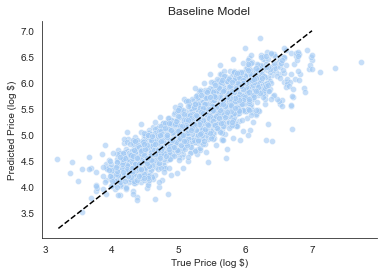

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# run linear regression
X, y = df[["stars", "reviews", "rating"] + CATEGORIES + list(pd.get_dummies(df["city"]).columns)], df["price"]
reg = LinearRegression().fit(X, y)
predicted = reg.predict(X)
print("Score:", reg.score(X, y))

# plot the data
sns.set_style("white")
sns.set_palette("pastel")
sns.scatterplot(x=y, y=predicted, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Baseline Model")
sns.despine()
plt.savefig("../figures/baseline_model.png", dpi=200)
plt.show()

In [18]:
df.columns

Index(['name', 'city', 'description', 'stars', 'price', 'rating', 'reviews',
       'image', 'images', 'categoryReviews', 'userReviews', 'staff',
       'facilities', 'cleanliness', 'comfort', 'valueForMoney', 'location',
       'austin', 'calgary', 'charlotte', 'chicago', 'columbus', 'dallas',
       'denver', 'fort_worth', 'houston', 'indianapolis', 'jacksonville',
       'las_vegas', 'los_angeles', 'montreal', 'new_york', 'orlando',
       'philadelphia', 'phoenix', 'san_antonio', 'san_diego', 'san_francisco',
       'san_jose', 'seattle', 'toronto'],
      dtype='object')